In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# import optuna

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision

import time

import random
from PIL import Image
import cv2

In [2]:
%cd /home/spyros/Desktop/DNN/
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
data.head()

/home/spyros/Desktop/DNN


,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
16378,HAM_0000358,ISIC_0026976,mel,histo,60,male,back,False,HAM10000_images_part_1/mel/ISIC_0026976.jpg,3
18516,HAM_0004409,ISIC_0027888,vasc,consensus,40,male,trunk,False,HAM10000_images_part_1/vasc/ISIC_0027888.jpg,4
30208,HAM_0000931,ISIC_0028820,akiec,histo,80,male,lower extremity,False,HAM10000_images_part_1/akiec/ISIC_0028820.jpg,6
21922,HAM_0006406,ISIC_0026336,vasc,consensus,50,male,trunk,False,HAM10000_images_part_1/vasc/ISIC_0026336.jpg,4
25458,HAM_0006843,ISIC_0024457,bcc,histo,85,male,face,False,HAM10000_images_part_1/bcc/ISIC_0024457.jpg,5


# Preprocessing

**Normalize function**

In [3]:
img_h, img_w = 224, 224

In [4]:
def compute_img_mean_std(image_paths,img_h,img_w):
    """
    Computing the mean and standard deviation of three channels on the whole dataset,
    without loading all images into memory at once. More time consuming but does not 
    fill up all the RAM.

    Args: image_paths (list): list of image paths
          img_h (int): height in pixels to resize
          img_w (int): width in pixels to resize

    Returns: 
        means (list): mean values of RGB channels
        stdevs (list): standard deviations of RGB channels
    """
    n_images = len(image_paths)
    channel_sum = np.zeros(3)
    channel_sum_squared = np.zeros(3)

    for path in tqdm(image_paths):
        img = cv2.imread(path) # Default BGR image
        img = cv2.resize(img, (img_h, img_w)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGR to RGB
        img = img.astype(np.float32) / 255.0

        channel_sum += np.sum(img, axis=(0, 1))
        channel_sum_squared += np.sum(np.square(img), axis=(0, 1))

    # Calculate mean and standard deviation
    means = channel_sum / (img_h * img_w * n_images)
    stdevs = np.sqrt(channel_sum_squared / (img_h * img_w * n_images) - np.square(means))

    print("Means = {}".format(means))
    print("Stds = {}".format(stdevs))
    return means, stdevs

In [5]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

In [6]:
norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

**Data Augmentation and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [7]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [8]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
16378,HAM_0000358,ISIC_0026976,mel,histo,60,male,back,False,HAM10000_images_part_1/mel/ISIC_0026976.jpg,3
18516,HAM_0004409,ISIC_0027888,vasc,consensus,40,male,trunk,False,HAM10000_images_part_1/vasc/ISIC_0027888.jpg,4
30208,HAM_0000931,ISIC_0028820,akiec,histo,80,male,lower extremity,False,HAM10000_images_part_1/akiec/ISIC_0028820.jpg,6
21922,HAM_0006406,ISIC_0026336,vasc,consensus,50,male,trunk,False,HAM10000_images_part_1/vasc/ISIC_0026336.jpg,4
25458,HAM_0006843,ISIC_0024457,bcc,histo,85,male,face,False,HAM10000_images_part_1/bcc/ISIC_0024457.jpg,5


**Data Loading**

In [9]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx_cat',img_col='image_path', transform=None):
        self.data = data
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx][self.img_col]
        image = Image.open(image_path) #RGB format

        label = torch.tensor(self.data.iloc[idx][self.label_column])

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [11]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


**Batch check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


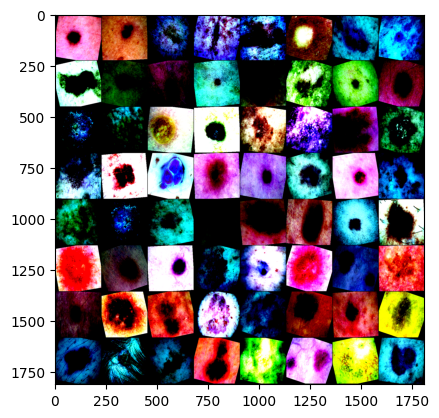

Labels:  tensor([1, 1, 0, 0, 3, 2, 5, 5, 0, 4, 1, 4, 2, 5, 5, 1, 2, 6, 0, 6, 6, 6, 1, 6,
        6, 6, 4, 2, 4, 2, 1, 3, 0, 2, 5, 4, 1, 1, 1, 2, 2, 1, 4, 0, 4, 2, 4, 0,
        1, 2, 1, 6, 0, 1, 4, 1, 3, 5, 0, 1, 6, 4, 6, 5])


In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

# Make the custom model

In [13]:
num_classes = 7

In [14]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(16),            
        nn.ReLU(),            
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = x.view(-1, 3, img_h, img_w)
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        out = out4.view(out4.size(0), -1) #makes them flat
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

CNN_model = CNNet()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [16]:
CNN_model = CNN_model.to(device)
input_size = (3, 224, 224)
summary(CNN_model, input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-3)

In [18]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy


In [19]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(val_loader)
    valid_accuracy = 100 * correct / total
    return avg_valid_loss, valid_accuracy


In [20]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy


In [21]:
def train_and_validate_model(model, train_loader, val_loader, test_loader, criterion, patience, optimizer, device, epochs):
    min_valid_loss = np.inf

    total_loss_train = []
    total_loss_val = []
    total_acc_train = []
    total_acc_val = []
    stopping_ct = 0

    for epoch in tqdm(range(epochs)):
        if stopping_ct < patience:            
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            valid_loss, valid_acc = validate_epoch(model, val_loader, criterion, device)

            total_loss_train.append(train_loss)
            total_loss_val.append(valid_loss)
            total_acc_train.append(train_acc)
            total_acc_val.append(valid_acc)
        
            print(f'Epoch {epoch+1}')
            print(f'Training Loss: {train_loss} \nTraining Accuracy: {train_acc}%')
            print(f'Validation Loss: {valid_loss} \nValidation Accuracy: {valid_acc}%')
            print('=======================================================================')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \nSaving The Model')
            print('=======================================================================')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), 'CNN_model.pth')
            stopping_ct = 0
        else:
            stopping_ct += 1

    best_model_state = torch.load('CNN_model.pth')
    model.load_state_dict(best_model_state)
    test_accuracy = test_model(model, test_loader, device)
    print('-------------------------------------------------------')
    print(f'Best models accuracy {test_accuracy}')
    print('-------------------------------------------------------')
    return model,total_loss_train, total_loss_val, total_acc_train, total_acc_val

**Fit the model using Validation set for the best model selection**

In [22]:
epochs = 25
patience = 3
CNN_model_fitted, total_loss_train, total_loss_val, total_acc_train, total_acc_val = train_and_validate_model(
                        CNN_model, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs)

  4%|▍         | 1/25 [00:49<19:57, 49.88s/it]

Epoch 1
Training Loss: 1.5089916494703783 
Training Accuracy: 45.971525643099824%
Validation Loss: 1.129734787744345 
Validation Accuracy: 58.57466429380359%
Validation Loss Decreased(inf--->1.129735) 
Saving The Model


  8%|▊         | 2/25 [01:39<19:05, 49.79s/it]

Epoch 2
Training Loss: 1.0158677451389353 
Training Accuracy: 62.506066979453166%
Validation Loss: 0.9387543855868664 
Validation Accuracy: 65.22407377447016%
Validation Loss Decreased(1.129735--->0.938754) 
Saving The Model


 12%|█▏        | 3/25 [02:29<18:14, 49.76s/it]

Epoch 3
Training Loss: 0.8199540247622225 
Training Accuracy: 69.29299466105807%
Validation Loss: 0.7510639435237216 
Validation Accuracy: 72.35884161138975%
Validation Loss Decreased(0.938754--->0.751064) 
Saving The Model


 16%|█▌        | 4/25 [03:19<17:25, 49.76s/it]

Epoch 4
Training Loss: 0.7217139856717021 
Training Accuracy: 72.81993204983013%
Validation Loss: 0.6785941508012948 
Validation Accuracy: 75.30334897265814%
Validation Loss Decreased(0.751064--->0.678594) 
Saving The Model


 20%|██        | 5/25 [04:09<16:37, 49.85s/it]

Epoch 5
Training Loss: 0.6655997913522819 
Training Accuracy: 75.20627730140754%
Validation Loss: 0.6447515055998084 
Validation Accuracy: 76.37922666235237%
Validation Loss Decreased(0.678594--->0.644752) 
Saving The Model


 24%|██▍       | 6/25 [04:58<15:46, 49.82s/it]

Epoch 6
Training Loss: 0.5968647702145822 
Training Accuracy: 77.60880116486005%
Validation Loss: 0.5872009914253176 
Validation Accuracy: 78.01326646173759%
Validation Loss Decreased(0.644752--->0.587201) 
Saving The Model


 28%|██▊       | 7/25 [05:48<14:56, 49.83s/it]

Epoch 7
Training Loss: 0.5168273660939994 
Training Accuracy: 80.80407701019253%
Validation Loss: 0.5408209451695078 
Validation Accuracy: 79.81718168581136%
Validation Loss Decreased(0.587201--->0.540821) 
Saving The Model


 32%|███▏      | 8/25 [06:38<14:04, 49.68s/it]

Epoch 8
Training Loss: 0.4813597080941053 
Training Accuracy: 82.36531305613978%
Validation Loss: 0.48011204024258347 
Validation Accuracy: 82.46238472739039%
Validation Loss Decreased(0.540821--->0.480112) 
Saving The Model


 36%|███▌      | 9/25 [07:27<13:13, 49.60s/it]

Epoch 9
Training Loss: 0.43077015999666196 
Training Accuracy: 84.0317100792752%
Validation Loss: 0.3927020468969935 
Validation Accuracy: 85.5686782074098%
Validation Loss Decreased(0.480112--->0.392702) 
Saving The Model


 40%|████      | 10/25 [08:17<12:24, 49.65s/it]

Epoch 10
Training Loss: 0.38875488867771996 
Training Accuracy: 85.46351723022164%
Validation Loss: 0.34477246629515873 
Validation Accuracy: 87.7447015046109%
Validation Loss Decreased(0.392702--->0.344772) 
Saving The Model


 44%|████▍     | 11/25 [09:06<11:35, 49.65s/it]

Epoch 11
Training Loss: 0.36628174105870354 
Training Accuracy: 86.45041255460282%
Validation Loss: 0.48161482426923574 
Validation Accuracy: 82.6241708461414%


 48%|████▊     | 12/25 [09:56<10:44, 49.59s/it]

Epoch 12
Training Loss: 0.3606129015229412 
Training Accuracy: 86.9762174405436%
Validation Loss: 0.32150559104287746 
Validation Accuracy: 88.16534541336354%
Validation Loss Decreased(0.344772--->0.321506) 
Saving The Model


 52%|█████▏    | 13/25 [10:45<09:53, 49.45s/it]

Epoch 13
Training Loss: 0.3301693651940405 
Training Accuracy: 88.18961333117619%
Validation Loss: 0.32484234688976377 
Validation Accuracy: 88.14916680148843%


 56%|█████▌    | 14/25 [11:35<09:06, 49.72s/it]

Epoch 14
Training Loss: 0.2925152212534983 
Training Accuracy: 89.0713476783692%
Validation Loss: 0.2748591276173739 
Validation Accuracy: 90.47079760556544%
Validation Loss Decreased(0.321506--->0.274859) 
Saving The Model


 60%|██████    | 15/25 [12:25<08:16, 49.69s/it]

Epoch 15
Training Loss: 0.29316365000667033 
Training Accuracy: 89.71849215337323%
Validation Loss: 0.5161567815032202 
Validation Accuracy: 82.6727066817667%


 64%|██████▍   | 16/25 [13:14<07:26, 49.64s/it]

Epoch 16
Training Loss: 0.2738362635994695 
Training Accuracy: 90.36563662837729%
Validation Loss: 0.2770153235682507 
Validation Accuracy: 90.28474356900178%


 68%|██████▊   | 17/25 [14:05<06:38, 49.82s/it]

Epoch 17
Training Loss: 0.2548187332439054 
Training Accuracy: 90.92379873806827%
Validation Loss: 0.23315011197221033 
Validation Accuracy: 91.77317586151108%
Validation Loss Decreased(0.274859--->0.233150) 
Saving The Model


 72%|███████▏  | 18/25 [14:55<05:49, 49.91s/it]

Epoch 18
Training Loss: 0.2298352183562886 
Training Accuracy: 91.53858598932212%
Validation Loss: 0.25356539254336014 
Validation Accuracy: 91.10176346869439%


 76%|███████▌  | 19/25 [15:44<04:58, 49.74s/it]

Epoch 19
Training Loss: 0.22143774919365486 
Training Accuracy: 92.0967480990131%
Validation Loss: 0.21989464988336735 
Validation Accuracy: 92.37178450088982%
Validation Loss Decreased(0.233150--->0.219895) 
Saving The Model


 80%|████████  | 20/25 [16:34<04:09, 49.90s/it]

Epoch 20
Training Loss: 0.19628576280971624 
Training Accuracy: 92.8975893868306%
Validation Loss: 0.22988798607563235 
Validation Accuracy: 91.78935447338618%


 84%|████████▍ | 21/25 [17:24<03:19, 49.81s/it]

Epoch 21
Training Loss: 0.21406471905941815 
Training Accuracy: 92.33942727713962%
Validation Loss: 0.23747231849690073 
Validation Accuracy: 91.52240737744701%


 88%|████████▊ | 22/25 [18:15<02:30, 50.12s/it]

Epoch 22
Training Loss: 0.19705719299153568 
Training Accuracy: 92.98657175214366%
Validation Loss: 0.18542384360100805 
Validation Accuracy: 94.01391360621258%
Validation Loss Decreased(0.219895--->0.185424) 
Saving The Model


 92%|█████████▏| 23/25 [19:05<01:40, 50.12s/it]

Epoch 23
Training Loss: 0.19523115657730816 
Training Accuracy: 93.4557514965216%
Validation Loss: 0.2198960876725998 
Validation Accuracy: 92.1129267108882%


 96%|█████████▌| 24/25 [19:54<00:49, 49.92s/it]

Epoch 24
Training Loss: 0.2183513747739423 
Training Accuracy: 92.18573046432616%
Validation Loss: 0.25351786945668076 
Validation Accuracy: 91.3282640349458%


100%|██████████| 25/25 [20:45<00:00, 49.81s/it]

Epoch 25
Training Loss: 0.16933077930943252 
Training Accuracy: 93.94919915871218%
Validation Loss: 0.1694046985550025 
Validation Accuracy: 94.45882543277787%
Validation Loss Decreased(0.185424--->0.169405) 
Saving The Model


-------------------------------------------------------
Best models accuracy 94.48309335059052
-------------------------------------------------------


In [23]:
# # Test the model
# test_accuracy = test_model(CNN_model_fitted, test_loader, device)
# print('-------------------------------------------------------')
# print(f'Best models accuracy {test_accuracy}')
# print('-------------------------------------------------------')

In [24]:
# torch.save(CNN_model, 'best_CNN_model.pth')

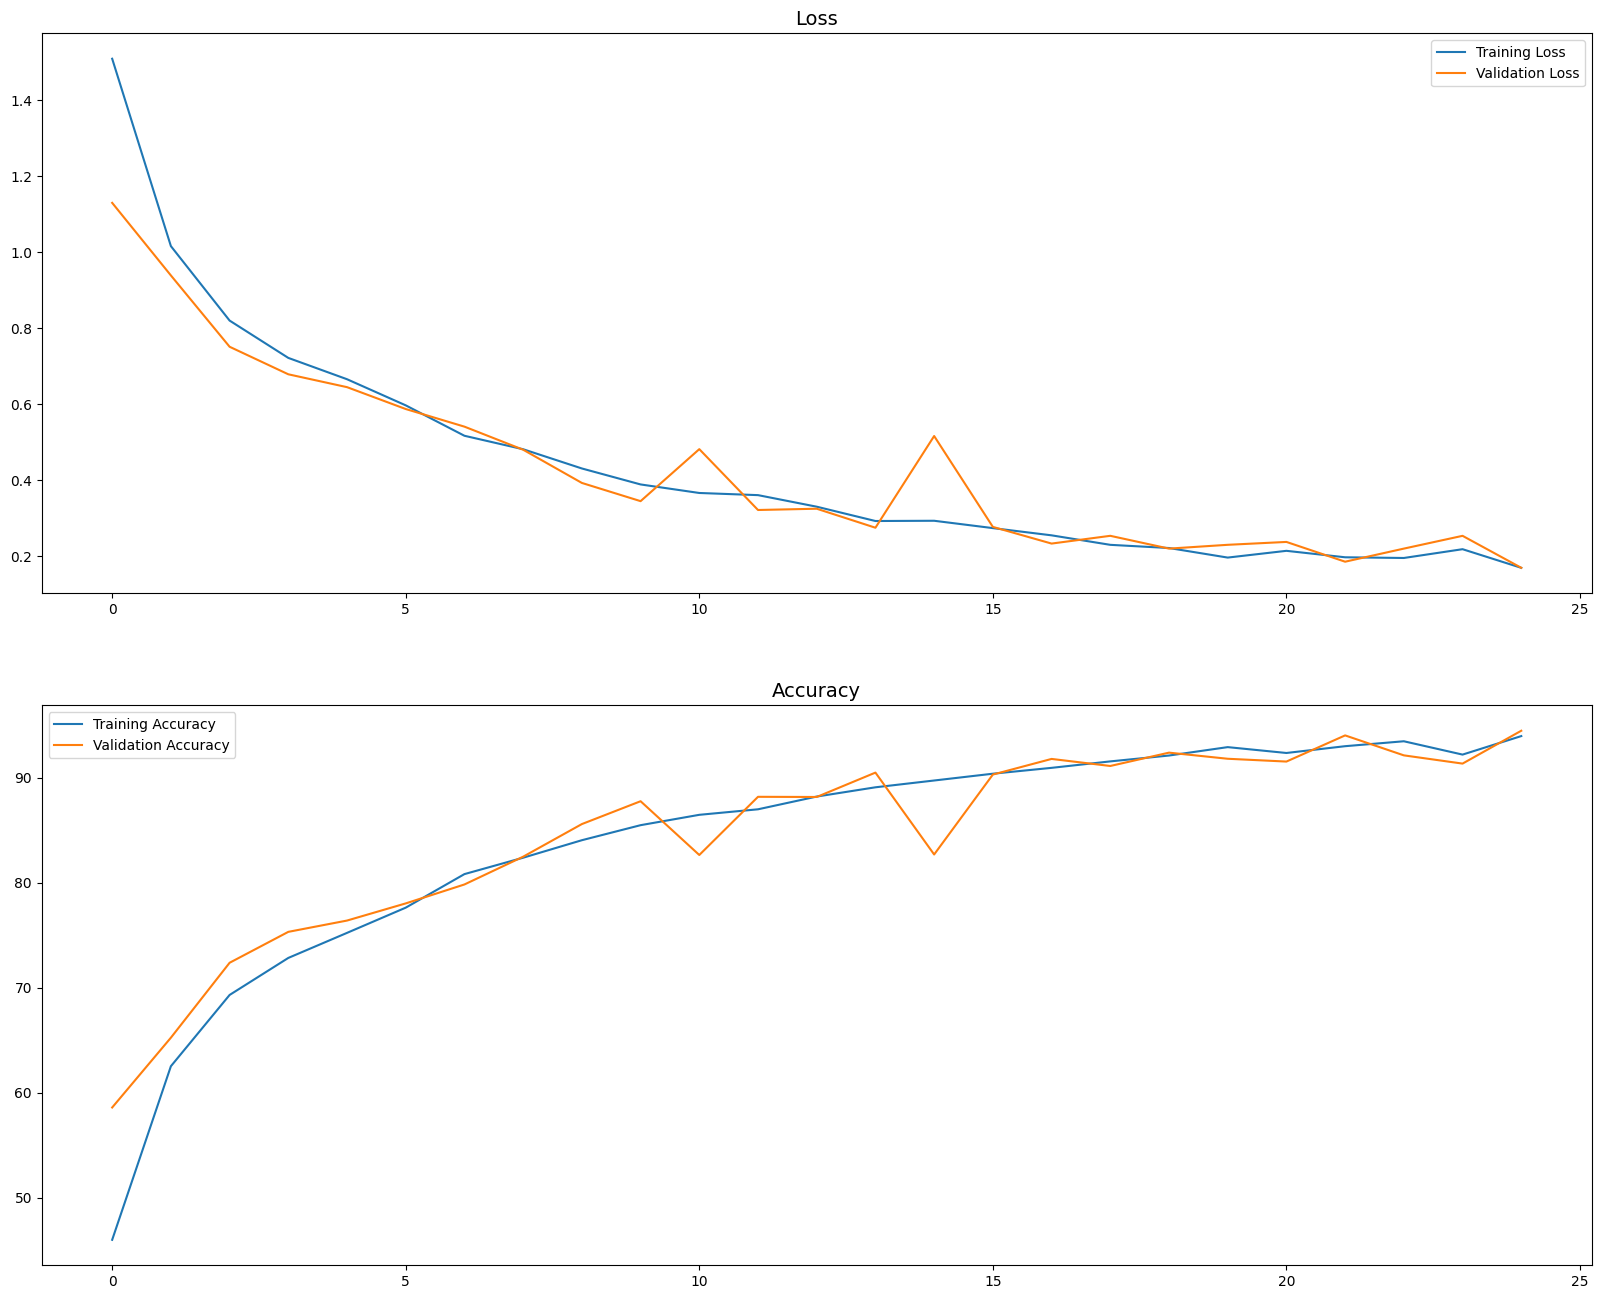

In [25]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy', fontsize=14)  
fig2.legend()
plt.show()

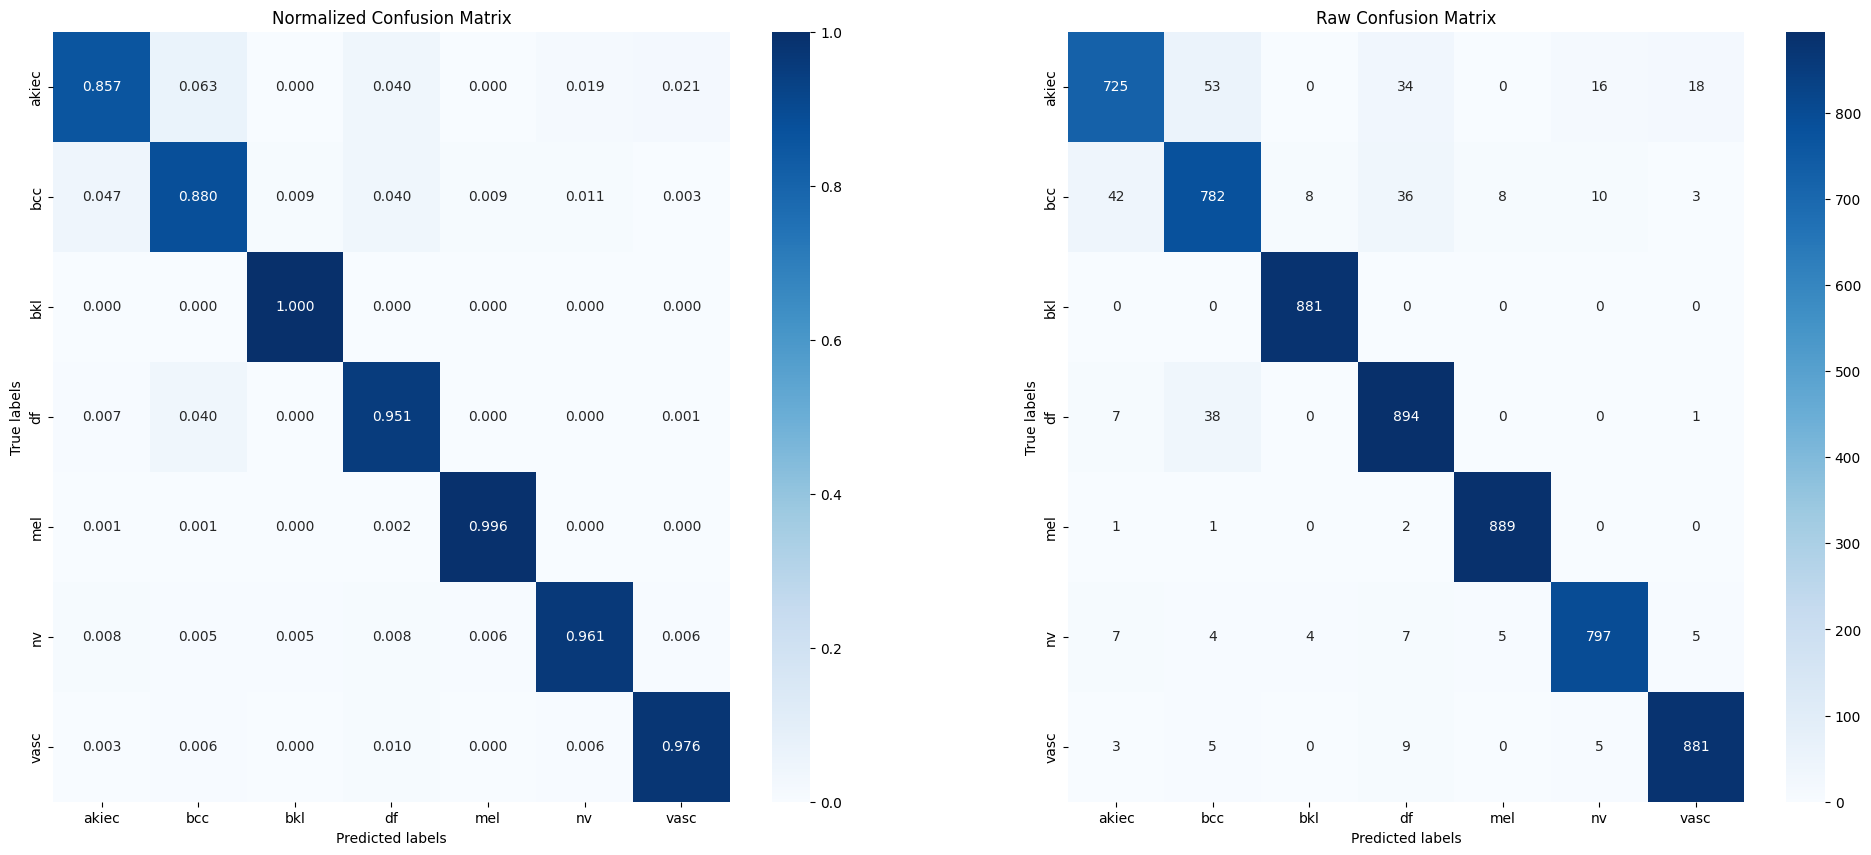

In [26]:
y_pred = []
y_true = []

for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)
    output = CNN_model_fitted(data)
    output = output.max(1)[1].data.cpu().numpy()
    y_pred.extend(output)
    labels = labels.cpu().numpy()
    y_true.extend(labels)

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis], index=classes, columns=classes)

plt.figure(figsize=(24, 10))  

plt.subplot(1, 2, 1)  
sns.heatmap(df_cm, annot=True, fmt=".3f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)  
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Raw Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.savefig('Confusion_Matrix.png')
plt.show()

In [27]:
# Test the model
test_accuracy = test_model(CNN_model_fitted, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 94.2889500080893
-------------------------------------------------------


# Pretrainned model

In [28]:
# transfer learning 
#learning by updating pre trained weights or not and updating last layer only
def set_para_req_grad(model, grad):
    if grad == True:
        for param in mode.parameters():
            param.requires_grad = False



In [29]:
from torchvision import models,transforms
models.resnet50(),models.densenet121()

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [30]:
def initialise_model(model_name, num_classes, grad, use_pretrained=True):
    '''
    grad = if the pretrained weights be updated
    use_pretrained = use pre trained weights or start from scratch
    '''
    model = None
    
    if model_name == 'resnet':
        model = models.resnet50(pretrained=use_pretrained)
        set_para_req_grad(model, grad)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=use_pretrained)
        set_para_req_grad(model,grad)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    return model



In [31]:
model_name = 'densenet'
grad = False
model_des = initialise_model(model_name, num_classes, grad, use_pretrained=True)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
